# Tutorial

Our goal is to solve a PDE-constrained inverse problem
on a product function space:
we have data that we model as being noisy observations of a function $u(x)$,
and that function $u$ is known to solve a PDE;
our aim is to infer the (spatially varying) parameters that drive that PDE.
The unknown quantities, as well as the only partially and noisily-observed unknown $u$,
are *functions*, and the PDE can be thought of as a map from functions (its spatially varying parameters)
to functions (the solutions).

So, to do this, below we will:

1. set up a (discretized) function space in which we can work
2. set up the PDE (i.e., the forwards problem)
3. define the way we choose a best solution, based on closeness of the data to the solution
    and regularization terms (i.e., the loss function), and
4. find the best-fitting function (i.e., solve the inverse problem).

In [1]:
import numpy as np
import scipy.sparse as sps
import pandas as pd
import product_fem as pf
import fenics as fx
import matplotlib.pyplot as plt

# Preliminaries

Outline: 

1. Defining function spaces and product function spaces
2. Defining functions and getting values from them
3. Plotting (note that many objects have `.plot( )` methods)

We first choose a space of functions over which to solve the problem.
These will be *continuous* functions, but they are defined using a discrete mesh.
In the following code, we divide the unit square into sixteen pieces
at the locations of a 5x5 mesh grid,
and then $V$ will be the space of continuous functions
that are piecewise linear (degree=1) on each of those pieces ("continuous Galerkin").
Our unknowns will be functions of locations, and so will be functions $g \in V$.

However, our data are functions of *two* locations,
for which we'll be working in the *product* space:
a function in $W$ is of the form
$$
   f(x, y) = g_1(x) g_2(y),
$$
for some $g_1$ and $g_2$ in $V$.

In [2]:
n = 5
mesh = fx.UnitSquareMesh(n-1, n-1)
V = fx.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)

Here is, for instance, what one of the basis functions in $V$ looks like:

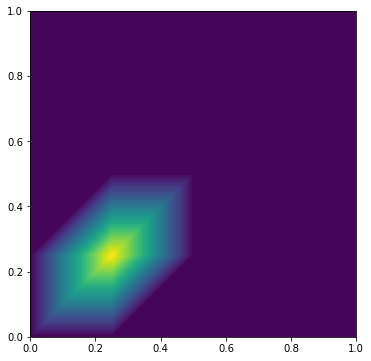

In [3]:
g = pf.functions.BasisFunction(V, 11)
fig, ax = plt.subplots(figsize=(6, 6))
fx.plot(g);

We can also make function objects from expressions:

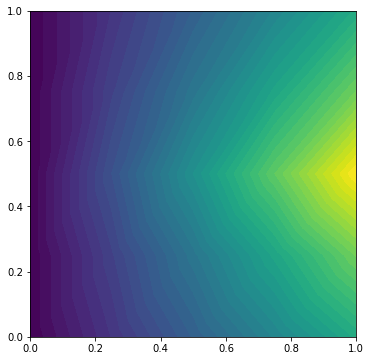

In [4]:
g = pf.to_Function("x[0] * exp(-abs(x[1] - 0.5))", V)
fig, ax = plt.subplots(figsize=(6, 6))
fx.plot(g);

It is harder to visualize functions in $W$, because they are functions of $\mathbb{R}^4$,
but we may plot slices of them.
Here, we plot the function
$$
   f(x, y) = x_0 + x_1 e^{-(y_0 + y_1 - 1)^2}
$$
as a function of $y$ at the "slice" $x = (0.2, 0.5)$.
(This reference point, $x$, will be marked with a star in the plot.)
Note that although our *basis* for $W$ is functions of the form $f(x, y) = g(x) g(y)$,
this is invisible to the user - the functions themselves need not be of that form.

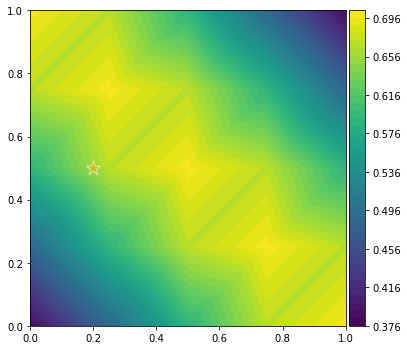

In [5]:
f = pf.ProductFunction(W)
f.assign(lambda x, y: x[0] + x[1] * np.exp(-(y[0] + y[1] - 1)**2))
f.plot((0.2, 0.5))

We can also evaluate functions like $f$ at particular points.
Here is the value of $f(x, y)$, where $x = (0.2, 0.4)$ and $y=(0, 1)$.

In [6]:
f((0.2, 0.4), (0, 1))

0.6000000000000001

# The forwards problem

0. write down math problem
1. boundary conditions
2. diagonal boundary epsilon stuff
3. equation object
4. update control (note equation comes with a default)
5. solve
6. plot

We will want to solve a PDE to find "coalescence times" for diffusions.
Suppose that we have a diffusion that when at location $x$
moves with mean $\mu(x) dt$ and covariance $K(x) dt$ over an amount of time $dt$.
(Note that here $\mu$ and $K$ can both depend on location.)
Then, if we let $u(x, y)$ be the mean time until *two* independent copies of this diffusion
begun at $x$ and $y$ respectively
are first are within distance $\epsilon$,
then $u(x, y)$ satisfies, for $|x - y| > \epsilon$,

$$\begin{aligned}
\frac{1}{2} \sum_{ij} K_{ij}(x) \partial_{x_i} \partial_{x_j} u(x, y) + \sum_i \mu_i(x) \partial_{x_i} u(x, y) = -1 
\\
\frac{1}{2} \sum_{ij} K_{ij}(y) \partial_{y_i} \partial_{y_j} u(x, y) + \sum_i \mu_i(y) \partial_{y_i} u(x, y) = -1 
\end{aligned}$$

and $u(x, y) = 0$ for $|x - y| = \epsilon$.

Now, generalize the problem slightly so that the diffusions stay within some region $\Omega$,
reflecting off the boundaries of $\Omega$,
and also let $u(x, y)$ be the mean time as above plus some value $u_0(x,y)$
that depends on where the diffusions hit the set $\{x, y \;:\; |x-y| = \epsilon\}$.
Then, $u(x, y)$ is as above for $x, y \in \Omega$,
with reflecting boundary conditions on $(\Omega \times \partial \Omega) \cup (\partial \Omega \times \Omega)$
and with the condition that $u(x, y) = u_0(x, y)$ for $|x - y| = \epsilon$.

Our first goal is to find $u(x, y)$ given $\mu$, $K$, $\epsilon$, and $u_0$ (and, of course, $\Omega$).
We have set up $\Omega$ above (this was $V$);
now, we provide $\epsilon$ and $u_0$ to set up the Equation object
that will solve the problem for us as a function of $\mu$ and $K$.
Here we set $u_0$ to a constant, and $\epsilon = 0.01$.

In [7]:
eqn = pf.equations.HittingTimes(W, u_bdy=0.3, epsilon=0.01)

Now, let's choose $\mu$ and $K$.
First, we need to know how they are parameterized.
Consulting the documentation, we see that $\mu$ is a straightforward vector field
(so, a function with "value dimension" 2),
and that $K$ is parameterized via a log-Cholesky decomposition with three free parameters,
so that if the parameters are $(a_0, a_1, a_2)$ then
$K = L^T L$ with $L_{00} = e^{a_0}$, $L_{11} = e^{a_1}$, and $L_{01} = a_2$.
We can verify this by extracting the default *control* objects from the Equation
and examining their "value dimension":

In [8]:
mu, K = eqn.control
mu.value_dim(), K.value_dim()

(2, 3)

First, let's set $\mu(x)$ to be the gradient of $|x - (0.5, 0.5)|^2 / 2$,
i.e., $\mu(x) = (x_0 - 0.5, x_1 - 0.5)$:

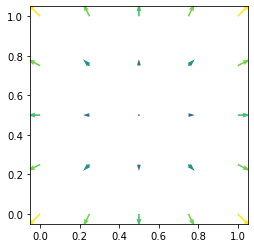

In [9]:
new_mu = pf.to_Function(lambda x, y: [x - 0.5, y - 0.5], V)
new_mu.plot();

Next, let's choose $K$ so that the two coordinates are not correlated
but the variances along each axis are largest transverse to $\mu$:
$a_0(x) = x_1 - 0.5$, $a_1(x) = x_0 - 0.5$, and $a_2(x) = 0$.
We don't have an easy way to plot this one, as it's three-dimensional.

In [10]:
new_K = pf.to_Function(lambda x, y: [y - 0.5, x - 0.5, 0], V)

Now, we just need to hand the Equation
something of the same form as its Control object
to get a solution back in return.
Recall that the solution, $u$, is a ProductFunction,
i.e., a function that takes *two* arguments in $\mathbb{R}^2$,
so to plot it we need to choose a slice.
Here we'll plot $u(x, y)$ as a function of $y$, with $x$ fixed:

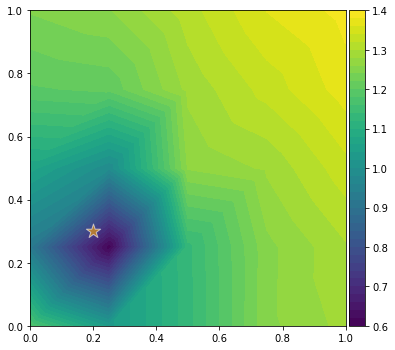

In [11]:
u = eqn.solve([mu, K])
u.plot(x=(0.2, 0.3))

Note that the Equation comes with a *default* control
(that happens to be $\mu = 0$ and $K = I/4$),
so we could have asked for a solution just by running `eqn.solve()`,
which would return the solution with the default control.

# The loss functional

0. write down math, discuss regularization
1. define some data (currently PDE solution-like, ie product function)
2. get control, regularization coefficients
3. define loss functional object
4. compute a few losses (maybe show it's a local min?)

Next we define a loss function, i.e., the quantity we seek to minimize
by adjusting the controls to the equation.
This will be of the form "how close is the solution to the equation to our data"
plus some regularizing terms.
So, suppose that $u_d$ is "data", i.e., an empirically observed product function,
and $m$ is the "control" to the equation (as above),
and $u$ is the solution to the equation with control $m$.
We'll then set up the loss function

$$
    J(u, m; u_d, \alpha, \beta) = 
        \iint_{\Omega^2}\! (u(x,y) - u_d(x,y))^2\, dxdy 
        + \frac{\alpha}{2}\int_\Omega\! m \cdot m\,dx 
        + \frac{\beta}{2}\int_\Omega\! \nabla m \cdot \nabla m \,dx
$$

Here $\alpha$ and $\beta$ are the relative strengths of the $L^2$ regularization terms
on $m$ and $\nabla m$, respectively,
referred to as the `l2` and `smoothing` terms.

As written, this doesn't at first make sense, since $u$ is uniquely determined by $m$,
but it turns out to be useful.
For our purposes here, we want to minimize $J(u,m)$ *subject to the constraint*
that $u$ is the solution to the equation produced by $m$.
This function, which we'll call $\widehat{J}$ (or, `Jhat`),
is a function of *only* $m$.

Recall also that our `control` object $m$ has two components, $\mu$ and $\sigma$.
So, when we define a `LossFunctional`, we can provide different values of $\alpha$ and $\beta$
for each, through a dictionary with keys `"l2"` and `"smoothing"`.
Here, $\alpha = 10^{-6}$ for $\mu$ and $\alpha = 10^{-4}$ for $\sigma$:

In [17]:
m = eqn.control
J = pf.LossFunctional(u, m, {'l2': [1e-6, 1e-4], 'smoothing': [1e-1, 1e-1]})
J(u, [new_mu, new_K])


AssertionError: 

In [18]:
m.update([new_mu, new_K])
J(u, m)

0.20000841666666677

In [16]:
J.l2_reg.ufl_form.coefficients()

(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 414),
 Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=3)), 569))

In [13]:

def Jhat(m):
    u = eqn.solve(m)
    return J(u, m)

print(Jhat([new_mu, new_K])) # loss at truth

AssertionError: 

# The inverse problem

0. write down math
1. make inverse problem object (eqn, loss)
2. see, it works! (with `.optmize` method)